In [1]:
from modelos import comunio_pred_lib
import pandas as pd
from sklearn.model_selection import train_test_split
#import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
#from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#from lightgbm import LGBMRegressor as LGBR
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [2]:

def create_data_train(journey):
    
    comunio = pd.read_csv(f'../data/pruebas/comunio_J{journey}.csv')

    comunio = comunio.drop(['Matchs', 'Goals', 'Assists','Total_Points' ], axis=1)
    comunio = comunio.rename(columns={f'J_{journey -4}': 'J_4',
                                          f'J_{journey -3}': 'J_3',
                                          f'J_{journey -2}': 'J_2',
                                          f'J_{journey -1}': 'J_1',
                                          f'J_{journey}': 'J_Actual',
                                          'On_start_%' : 'On_start'
                                     })
    clas = pd.read_excel(f'../data/classification_J_{journey}.xlsx', 
                                     sheet_name=f'classification_J_{journey}', index_col='Unnamed: 0')
    cal = pd.read_csv('../data/pruebas/Season_21-22.csv')
    teams_dict = {'Athletic Club': 'Athletic Club' ,
                            'CA Osasuna':'Osasuna',
                            'Club Atlético de Madrid':'Atlético Madrid',
                            'Cádiz CF':'Cádiz',
                            'Deportivo Alavés':'Alavés',
                            'Elche CF':'Elche',
                            'FC Barcelona':'Barcelona',
                            'Getafe CF':'Getafe',
                            'Granada CF':'Granada',
                            'Levante UD':'Levante',
                            'RC Celta de Vigo':'Celta Vigo',
                            'RCD Espanyol de Barcelona':'Espanyol',
                            'RCD Mallorca':'Mallorca',
                            'Rayo Vallecano de Madrid':'Rayo Vallecano',
                            'Real Betis Balompié':'Betis',
                            'Real Madrid CF':'Real Madrid',
                            'Real Sociedad de Fútbol':'Real Sociedad',
                            'Sevilla FC':'Sevilla',
                            'Valencia CF':'Valencia',
                            'Villarreal CF':'Villarreal'}

    new_team_name = []
    for team in comunio.Team:

        for k,v in teams_dict.items():

            if k == team:

                new_team_name.append(v)

    comunio['Team'] = new_team_name

    points_per_team = comunio.groupby('Team').sum().reset_index()
    points_per_team= points_per_team.rename(columns={
                                                                'Points_Average': 'Squad_Average_Points',
                                                                'Avg_last_5_games': 'Squad_Avg_last_5_Games',
                                                                'Value': 'Value_Squad',
                                                                f'J_4': 'J_4_Squad_Points',
                                                                f'J_3': 'J_3_Squad_Points',
                                                                f'J_2': 'J_2_Squad_Points',
                                                                f'J_1': 'J_1_Squad_Points',
                                                                f'J_Actual': 'J_Actual_Squad_Points'})

    points_per_team = points_per_team.drop(['Team_id','On_start'], axis=1)

    df_1 = comunio.merge(points_per_team, how='left', left_on='Team', right_on='Team')

    matches_J = cal.loc[cal['Journey'] == (journey+1)]
    matches_J

    vs = []
    for team in df_1.Team:

        for index in matches_J.index:

            if team == matches_J.loc[index].Home:

                vs.append(matches_J.loc[index].Away)

            if team == matches_J.loc[index].Away:

                vs.append(matches_J.loc[index].Home)

    df_1['vs'] = vs

    points_per_vs_team = comunio.groupby('Team').sum().reset_index()
    points_per_vs_team= points_per_vs_team.rename(columns={
                                                                    'Team':'Vs_Team',
                                                                    'Points_Average': 'Vs_Squad_Average_Points',
                                                                    'Avg_last_5_games': 'Vs_Squad_Avg_last_5_Games',
                                                                    'Value':'Vs_Value_Squad',
                                                                    f'J_4': 'J_4_Vs_Squad_Points',
                                                                    f'J_3': 'J_3_Vs_Squad_Points',
                                                                    f'J_2': 'J_2_Vs_Squad_Points',
                                                                    f'J_1': 'J_1_Vs_Squad_Points',
                                                                    f'J_Actual': 'J_Actual_Vs_Squad_Points'})

    points_per_vs_team = points_per_vs_team.drop(['Team_id','On_start'], axis=1)

    df_2 = df_1.merge(points_per_vs_team, how='left', left_on='vs', right_on='Vs_Team')

    team_clas = []

    for team in comunio.Team:
        for index in clas.index:

            if team in clas.loc[index].Team:

                team_clas.append(clas.loc[index].Position)

    team_clas_vs = []

    for team in df_2.Vs_Team:
        for index in clas.index:

            if team in clas.loc[index].Team:

                team_clas_vs.append(clas.loc[index].Position)

    df_2['Team_clas'] = team_clas
    df_2['Vs_Team_clas'] = team_clas_vs
        
    df_2 = df_2.drop('Team_id', axis=1)
        
       
    return df_2
    
    
        

 

In [3]:
j = [19,20,21,23,25,26,27,28,29,30,31,32,33,34]

df = pd.DataFrame()
for journey in j:
    if journey != 21 and journey != 23:
        print('Jornada Actual',journey)
        df_2 = create_data_train(journey)

        n_j = journey+1
        print('Siguiente jornada',n_j)
        next_j = create_data_train(n_j)
        next_j = next_j[['Player','J_Actual']]
        next_j_target= next_j.rename(columns={'Player': 'Jugador', 'J_Actual':'Target'})
        df_3 = df_2.merge(next_j_target, how='left', left_on='Player', right_on='Jugador')
        df_3 = df_3.dropna()
            
        
    
    else:
        print('Jornada Actual 21 o 23',journey)
        df_2 = create_data_train(journey)
        n_j = journey+2
        print('Siguiente jornada +2',n_j)
        next_j = create_data_train(n_j)
        next_j = next_j[['Player','J_1']]
        next_j_target= next_j.rename(columns={'Player': 'Jugador', 'J_1':'Target'})
        df_3 = df_2.merge(next_j_target, how='left', left_on='Player', right_on='Jugador')
        df_3 = df_3.dropna()

    df = df.append(df_3)

Jornada Actual 19
Siguiente jornada 20


C:\Users\botic\AppData\Local\Temp\ipykernel_31424\2590328670.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_3)


Jornada Actual 20
Siguiente jornada 21


C:\Users\botic\AppData\Local\Temp\ipykernel_31424\2590328670.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_3)


Jornada Actual 21 o 23 21
Siguiente jornada +2 23


C:\Users\botic\AppData\Local\Temp\ipykernel_31424\2590328670.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_3)


Jornada Actual 21 o 23 23
Siguiente jornada +2 25


C:\Users\botic\AppData\Local\Temp\ipykernel_31424\2590328670.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_3)


Jornada Actual 25
Siguiente jornada 26


C:\Users\botic\AppData\Local\Temp\ipykernel_31424\2590328670.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_3)


Jornada Actual 26
Siguiente jornada 27


C:\Users\botic\AppData\Local\Temp\ipykernel_31424\2590328670.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_3)


Jornada Actual 27
Siguiente jornada 28


C:\Users\botic\AppData\Local\Temp\ipykernel_31424\2590328670.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_3)


Jornada Actual 28
Siguiente jornada 29


C:\Users\botic\AppData\Local\Temp\ipykernel_31424\2590328670.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_3)


Jornada Actual 29
Siguiente jornada 30


C:\Users\botic\AppData\Local\Temp\ipykernel_31424\2590328670.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_3)


Jornada Actual 30
Siguiente jornada 31


C:\Users\botic\AppData\Local\Temp\ipykernel_31424\2590328670.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_3)


Jornada Actual 31
Siguiente jornada 32


C:\Users\botic\AppData\Local\Temp\ipykernel_31424\2590328670.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_3)


Jornada Actual 32
Siguiente jornada 33


C:\Users\botic\AppData\Local\Temp\ipykernel_31424\2590328670.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_3)


Jornada Actual 33
Siguiente jornada 34


C:\Users\botic\AppData\Local\Temp\ipykernel_31424\2590328670.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_3)


Jornada Actual 34
Siguiente jornada 35


C:\Users\botic\AppData\Local\Temp\ipykernel_31424\2590328670.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_3)


In [4]:
df.columns


Index(['Team', 'Player', 'Position', 'On_start', 'Points_Average',
       'Last_5_games_points', 'J_4', 'J_3', 'J_2', 'J_1', 'J_Actual',
       'Avg_last_5_games', 'Value', 'Squad_Average_Points', 'J_4_Squad_Points',
       'J_3_Squad_Points', 'J_2_Squad_Points', 'J_1_Squad_Points',
       'J_Actual_Squad_Points', 'Squad_Avg_last_5_Games', 'Value_Squad', 'vs',
       'Vs_Team', 'Vs_Squad_Average_Points', 'J_4_Vs_Squad_Points',
       'J_3_Vs_Squad_Points', 'J_2_Vs_Squad_Points', 'J_1_Vs_Squad_Points',
       'J_Actual_Vs_Squad_Points', 'Vs_Squad_Avg_last_5_Games',
       'Vs_Value_Squad', 'Team_clas', 'Vs_Team_clas', 'Jugador', 'Target'],
      dtype='object')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6383 entries, 0 to 580
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Team                       6383 non-null   object 
 1   Player                     6383 non-null   object 
 2   Position                   6383 non-null   object 
 3   On_start                   6383 non-null   int64  
 4   Points_Average             6383 non-null   float64
 5   Last_5_games_points        6383 non-null   object 
 6   J_4                        6383 non-null   int64  
 7   J_3                        6383 non-null   int64  
 8   J_2                        6383 non-null   int64  
 9   J_1                        6383 non-null   int64  
 10  J_Actual                   6383 non-null   int64  
 11  Avg_last_5_games           6383 non-null   float64
 12  Value                      6383 non-null   int64  
 13  Squad_Average_Points       6383 non-null   float6

In [6]:
df.to_csv('data_train_J_35.csv', index=False)

In [11]:
df.loc[df['Team']=='Mallorca']

,Team,Player,Position,On_start,Points_Average,Last_5_games_points,J_4,J_3,J_2,J_1,J_Actual,Avg_last_5_games,Value,Squad_Average_Points,J_4_Squad_Points,J_3_Squad_Points,J_2_Squad_Points,J_1_Squad_Points,J_Actual_Squad_Points,Squad_Avg_last_5_Games,Value_Squad,vs,Vs_Team,Vs_Squad_Average_Points,J_4_Vs_Squad_Points,J_3_Vs_Squad_Points,J_2_Vs_Squad_Points,J_1_Vs_Squad_Points,J_Actual_Vs_Squad_Points,Vs_Squad_Avg_last_5_Games,Vs_Value_Squad,Team_clas,Vs_Team_clas,Jugador,Target
238,Mallorca,Reina,PT,95,3.8,"['6', '11', '-2', '-', '3']",6,11,-2,0,3,3.6,2640000,70.2,60,50,32,0,42,36.8,41150000,Levante,Levante,66.0,56,39,42,0,14,30.2,39980000,15,20,Reina,0.0
239,Mallorca,Greif,PT,5,0.0,"['-', '-', '-', '-', '-']",0,0,0,0,0,0.0,330000,70.2,60,50,32,0,42,36.8,41150000,Levante,Levante,66.0,56,39,42,0,14,30.2,39980000,15,20,Greif,0.0
240,Mallorca,Maffeo,DF,89,4.8,"['2', '4', '2', '-', '1']",2,4,2,0,1,1.8,4210000,70.2,60,50,32,0,42,36.8,41150000,Levante,Levante,66.0,56,39,42,0,14,30.2,39980000,15,20,Maffeo,4.0
241,Mallorca,Martin Valjent,DF,100,3.4,"['2', '3', '1', '-', '2']",2,3,1,0,2,1.6,2190000,70.2,60,50,32,0,42,36.8,41150000,Levante,Levante,66.0,56,39,42,0,14,30.2,39980000,15,20,Martin Valjent,0.0
242,Mallorca,Franco Russo,DF,68,4.4,"['13', '3', '-', '-', '2']",13,3,0,0,2,3.6,1410000,70.2,60,50,32,0,42,36.8,41150000,Levante,Levante,66.0,56,39,42,0,14,30.2,39980000,15,20,Franco Russo,1.0
243,Mallorca,Brian Oliván,DF,63,3.4,"['-', '-', '1', '-', '-']",0,0,1,0,0,0.2,1770000,70.2,60,50,32,0,42,36.8,41150000,Levante,Levante,66.0,56,39,42,0,14,30.2,39980000,15,20,Brian Oliván,0.0
244,Mallorca,Jaume Costa,DF,47,2.9,"['7', '8', '7', '-', '2']",7,8,7,0,2,4.8,1560000,70.2,60,50,32,0,42,36.8,41150000,Levante,Levante,66.0,56,39,42,0,14,30.2,39980000,15,20,Jaume Costa,6.0
245,Mallorca,Sedlar,DF,11,1.3,"['2', '-', '2', '-', '-']",2,0,2,0,0,0.8,340000,70.2,60,50,32,0,42,36.8,41150000,Levante,Levante,66.0,56,39,42,0,14,30.2,39980000,15,20,Sedlar,3.0
247,Mallorca,Dani Rodríguez,MD,95,4.7,"['2', '4', '9', '-', '9']",2,4,9,0,9,4.8,4350000,70.2,60,50,32,0,42,36.8,41150000,Levante,Levante,66.0,56,39,42,0,14,30.2,39980000,15,20,Dani Rodríguez,0.0
248,Mallorca,Idrissu Baba,MD,79,4.7,"['3', '-', '2', '-', '2']",3,0,2,0,2,1.4,4850000,70.2,60,50,32,0,42,36.8,41150000,Levante,Levante,66.0,56,39,42,0,14,30.2,39980000,15,20,Idrissu Baba,0.0


In [3]:
def once_ideal_xbgr(data,df,mc,dl):
    gk = data.loc[data['Position']=='PT'].sort_values('xgb', ascending=False)[:1]
    df = data.loc[data['Position']=='DF'].sort_values('xgb', ascending=False)[:df]
    md = data.loc[data['Position']=='MD'].sort_values('xgb', ascending=False)[:mc]
    dl = data.loc[data['Position']=='DL'].sort_values('xgb', ascending=False)[:dl]
    positions = [gk, df, md, dl]
    squad = pd.DataFrame()
    for pos in positions:
        squad = squad.append(pd.DataFrame(pos))
    
    return squad
def once_ideal_rf(data,df,mc,dl):
    gk = data.loc[data['Position']=='PT'].sort_values('rfr', ascending=False)[:1]
    df = data.loc[data['Position']=='DF'].sort_values('rfr', ascending=False)[:df]
    md = data.loc[data['Position']=='MD'].sort_values('rfr', ascending=False)[:mc]
    dl = data.loc[data['Position']=='DL'].sort_values('rfr', ascending=False)[:dl]
    positions = [gk, df, md, dl]
    squad = pd.DataFrame()
    for pos in positions:
        squad = squad.append(pd.DataFrame(pos))
    
    return squad
def once_ideal_gb(data,df,mc,dl):
    gk = data.loc[data['Position']=='PT'].sort_values('gb', ascending=False)[:1]
    df = data.loc[data['Position']=='DF'].sort_values('gb', ascending=False)[:df]
    md = data.loc[data['Position']=='MD'].sort_values('gb', ascending=False)[:mc]
    dl = data.loc[data['Position']=='DL'].sort_values('gb', ascending=False)[:dl]
    positions = [gk, df, md, dl]
    squad = pd.DataFrame()
    for pos in positions:
        squad = squad.append(pd.DataFrame(pos))
    
    return squad
def once_ideal_rnn(data,df,mc,dl):
    gk = data.loc[data['Position']=='PT'].sort_values('rnn', ascending=False)[:1]
    df = data.loc[data['Position']=='DF'].sort_values('rnn', ascending=False)[:df]
    md = data.loc[data['Position']=='MD'].sort_values('rnn', ascending=False)[:mc]
    dl = data.loc[data['Position']=='DL'].sort_values('rnn', ascending=False)[:dl]
    positions = [gk, df, md, dl]
    squad = pd.DataFrame()
    for pos in positions:
        squad = squad.append(pd.DataFrame(pos))
    
    return squad

In [7]:
def preprocess_data(df):
    
    X = df.drop(['Target'], axis=1)._get_numeric_data()
    y = df.Target
    
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)
    
    X_train_s = x_scaler.fit_transform(X_train)
    X_test_s = x_scaler.transform(X_test)
    
    y_train_s = y_scaler.fit_transform(y_train.values.reshape(-1,1))
    y_test_s = y_scaler.transform(y_test.values.reshape(-1,1))
                    
    return X, y, X_train, X_test, y_train, y_test ,X_train_s, X_test_s, y_train_s, y_test_s, x_scaler, y_scaler

In [8]:
X, y, X_train, X_test, y_train, y_test ,X_train_s, X_test_s, y_train_s, y_test_s, x_scaler, y_scaler = preprocess_data(df)

KeyError: "['Target'] not found in axis"

In [15]:
X.shape, y.shape

((6383, 27), (6383,))

In [8]:
rfr = RandomForestRegressor(max_depth= 5, max_leaf_nodes= 35, n_estimators= 300, n_jobs= -1)
xgbr = XGBRegressor(max_depth=5, n_estimators=500,learning_rate=0.01, n_jobs=-1, gamma=0.1 )
gb = GradientBoostingRegressor(max_depth=5, n_estimators=400,learning_rate=0.001, alpha=0.8, max_leaf_nodes=35)
models = (rfr,xgbr,gb)

NameError: name 'XGBRegressor' is not defined

In [18]:
for model in models:
    name = str(model)[:13]
  
    model.fit(X_train_s,y_train)
    model.score(X_train_s, y_train)
    pred = model.predict(X_test_s)
    #pred2 = y_scaler.inverse_transform(pred.reshape(-1,1))
    mse = mean_squared_error(pred,y_test, squared=False)
    r2 = r2_score(pred, y_test)
    
    print (f'mse del modelo {name} = {mse}')

mse del modelo RandomForestR = 2.688690860877045
mse del modelo XGBRegressor( = 2.699368904734176
mse del modelo GradientBoost = 2.8521213134468826


In [6]:
rnn =  Sequential()

rnn.add(Dense(500, activation='relu',input_dim=27))
rnn.add(Dense(250, activation='relu'))
rnn.add(Dense(125, activation='relu'))
rnn.add(Dense(60, activation='relu'))
rnn.add(Dense(1, activation='linear'))

rnn.compile(loss="mean_squared_error",
             optimizer="adam")
his = rnn.fit(X_train_s,
        y_train_s,
        epochs=20,
        validation_split=0.2
        )
pred_rnn = rnn.predict(X_test_s)
pred2_rnn = y_scaler.inverse_transform(pred_rnn)
mse = mean_squared_error(pred2_rnn,y_test, squared=False)
r2 = r2_score(pred2_rnn, y_test)
        
'''pd.DataFrame(his.history).plot(figsize=(8,5))
plt.grid()
plt.show()'''

Epoch 1/20
142/142 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0050
Epoch 2/20
142/142 [==============================] - 0s 1ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 3/20
142/142 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 0.0054
Epoch 4/20
142/142 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 0.0068
Epoch 5/20
142/142 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 0.0053
Epoch 6/20
142/142 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.0050
Epoch 7/20
142/142 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.0051
Epoch 8/20
142/142 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 9/20
142/142 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.0054
Epoch 10/20
142/142 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.0049

'pd.DataFrame(his.history).plot(figsize=(8,5))\nplt.grid()\nplt.show()'

In [22]:
pd.DataFrame(his.history)

,loss,val_loss
0,0.006497,0.005248
1,0.005390,0.005116
2,0.005197,0.004976
3,0.005166,0.005778
4,0.005099,0.005251
5,0.005020,0.005156
6,0.005204,0.004902
7,0.004872,0.004951
8,0.004944,0.005579
9,0.005007,0.004962


In [7]:
print (f'mse del modelo rnn = {mse}')
print (f'R2 score del modelo rnn = {r2}')

mse del modelo rnn = 2.821270507654574
R2 score del modelo rnn = -1.4416229280898318


In [16]:
X_scal = x_scaler.transform(X)

In [21]:
rfr.fit(X,y)
xgbr.fit(X,y)
gb.fit(X,y)


GradientBoostingRegressor(alpha=0.8, learning_rate=0.001, max_depth=5,
                          max_leaf_nodes=35, n_estimators=400)

In [3]:
j_33 = create_data_train(37)
#j_34 = create_data_train(34)
#pred_data = j_33._get_numeric_data()

In [4]:
df = j_33.copy()

In [22]:
teams = df.Team.unique()
players = df.loc[df.Team == teams[2]]['Player']

In [16]:
teams

array(['Athletic Club', 'Atlético Madrid', 'Osasuna', 'Espanyol',
       'Barcelona', 'Getafe', 'Granada', 'Real Madrid', 'Rayo Vallecano',
       'Levante', 'Mallorca', 'Betis', 'Real Sociedad', 'Villarreal',
       'Valencia', 'Alavés', 'Cádiz', 'Elche', 'Celta Vigo', 'Sevilla'],
      dtype=object)

In [23]:
players

49         Sergio Herrera
50             Juan Pérez
51      David García Zub.
52            Nacho Vidal
53           Manu Sánchez
54        José Ángel Cote
55            Unai García
56              Juan Cruz
57      Aridane Hernández
58                Ramalho
59             Unai Dufur
60         Roberto Torres
61            Jesús Areso
62           Rubén García
63          Jon Moncayola
64            Lucas Torró
65               Brasanac
66    Javi Martínez Calvo
67             Kike Barja
68                   Oier
69            Iñigo Pérez
70            Iker Benito
71             Aimar Oroz
72         Ezequiel Ávila
73            Kike García
74                Budimir
75                Barbero
Name: Player, dtype: object

In [26]:
df[['Team','Player','Position','Points_Average','Value']]

,Team,Player,Position,Points_Average,Value
0,Athletic Club,Unai Simón,PT,4.5,3280000
1,Athletic Club,Agirrezabala,PT,5.0,360000
2,Athletic Club,Ezkieta,PT,0.0,180000
3,Athletic Club,Iñigo Martínez,DF,5.3,5460000
4,Athletic Club,Daniel Vivian,DF,5.1,3410000
5,Athletic Club,De Marcos,DF,4.7,1440000
6,Athletic Club,Yeray Álvarez,DF,4.4,2880000
7,Athletic Club,Lekue,DF,3.6,1250000
8,Athletic Club,Balenziaga,DF,3.2,1070000
9,Athletic Club,Yuri Berchiche,DF,5.7,4510000


In [12]:
j_33.to_json('j_33.json', orient='table')

In [10]:
j_33.columns

Index(['Team', 'Player', 'Position', 'On_start', 'Points_Average',
       'Last_5_games_points', 'J_4', 'J_3', 'J_2', 'J_1', 'J_Actual',
       'Avg_last_5_games', 'Value', 'Squad_Average_Points', 'J_4_Squad_Points',
       'J_3_Squad_Points', 'J_2_Squad_Points', 'J_1_Squad_Points',
       'J_Actual_Squad_Points', 'Squad_Avg_last_5_Games', 'Value_Squad', 'vs',
       'Vs_Team', 'Vs_Squad_Average_Points', 'J_4_Vs_Squad_Points',
       'J_3_Vs_Squad_Points', 'J_2_Vs_Squad_Points', 'J_1_Vs_Squad_Points',
       'J_Actual_Vs_Squad_Points', 'Vs_Squad_Avg_last_5_Games',
       'Vs_Value_Squad', 'Team_clas', 'Vs_Team_clas'],
      dtype='object')

In [46]:
ids = [i for i in range(1, len(j_34.Team)+1)]
j_34['id'] = ids

In [47]:
col = ['id','Team', 'Player', 'Position', 'On_start', 'Points_Average',
       'Last_5_games_points', 'J_4', 'J_3', 'J_2', 'J_1', 'J_Actual',
       'Avg_last_5_games', 'Value', 'Squad_Average_Points', 'J_4_Squad_Points',
       'J_3_Squad_Points', 'J_2_Squad_Points', 'J_1_Squad_Points',
       'J_Actual_Squad_Points', 'Squad_Avg_last_5_Games', 'Value_Squad', 'vs',
       'Vs_Team', 'Vs_Squad_Average_Points', 'J_4_Vs_Squad_Points',
       'J_3_Vs_Squad_Points', 'J_2_Vs_Squad_Points', 'J_1_Vs_Squad_Points',
       'J_Actual_Vs_Squad_Points', 'Vs_Squad_Avg_last_5_Games',
       'Vs_Value_Squad', 'Team_clas', 'Vs_Team_clas']

In [48]:
j_34 = j_34.reindex(columns=col)


In [49]:
j_34.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 579 entries, 0 to 578
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         579 non-null    int64  
 1   Team                       579 non-null    object 
 2   Player                     579 non-null    object 
 3   Position                   579 non-null    object 
 4   On_start                   579 non-null    int64  
 5   Points_Average             579 non-null    float64
 6   Last_5_games_points        579 non-null    object 
 7   J_4                        579 non-null    int64  
 8   J_3                        579 non-null    int64  
 9   J_2                        579 non-null    int64  
 10  J_1                        579 non-null    int64  
 11  J_Actual                   579 non-null    int64  
 12  Avg_last_5_games           579 non-null    float64
 13  Value                      579 non-null    int64  

In [24]:
rnn2 = keras.models.load_model('comunio_rnn.h5')

In [8]:
import pickle

In [5]:
pred_data = comunio_pred_lib.create_data_train(37)

In [6]:
pred_rfr = comunio_pred_lib.predict_rf(pred_data)
pred_xgb = comunio_pred_lib.predict_xgb(pred_data)
pred_gb = comunio_pred_lib.predict_gb(pred_data)
pred_rnn = comunio_pred_lib.predict_rnn(pred_data)
pred_rnn2 = comunio_pred_lib.predict_rnn2(pred_data)

[20:19:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[20:19:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[20:19:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.sav

C:\Users\botic\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


FileNotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ram://e93fe59f-0d41-4c05-bb09-94c9f357aba0/variables/variables
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.

In [54]:
preds = pd.DataFrame(j_33['Player'])
preds['Position'] = j_33.Position
preds['rfr'] = pred_rfr
preds['xgb'] = pred_xgb
preds['gb'] = pred_gb
preds['rnn'] = pred_rnn
preds['rnn2'] = pred_rnn2
preds = preds.merge(j_34[['Player','J_Actual']], left_on='Player', right_on='Player')
preds = round(preds)

preds

,Player,Position,rfr,xgb,gb,rnn,rnn2,J_Actual
0,Unai Simón,PT,3.0,3.0,2.0,2.0,3.0,8
1,Agirrezabala,PT,1.0,1.0,2.0,1.0,1.0,0
2,Ezkieta,PT,0.0,0.0,2.0,0.0,0.0,0
3,Iñigo Martínez,DF,2.0,1.0,2.0,2.0,2.0,5
4,Daniel Vivian,DF,3.0,2.0,2.0,2.0,2.0,4
5,De Marcos,DF,3.0,2.0,2.0,2.0,2.0,2
6,Yeray Álvarez,DF,3.0,2.0,2.0,2.0,2.0,6
7,Lekue,DF,2.0,2.0,2.0,1.0,2.0,0
8,Balenziaga,DF,2.0,2.0,2.0,1.0,2.0,2
9,Yuri Berchiche,DF,3.0,3.0,3.0,2.0,2.0,5


In [55]:
once_ideal_rf(preds,3,4,3)

,Player,Position,rfr,xgb,gb,rnn,rnn2,J_Actual
49,Sergio Herrera,PT,5.0,6.0,3.0,4.0,5.0,3
201,Éder Militão,DF,5.0,5.0,3.0,5.0,5.0,0
108,Jordi Alba,DF,5.0,5.0,3.0,6.0,6.0,9
203,Lucas Vázquez,DF,4.0,4.0,3.0,4.0,4.0,4
397,Parejo,MD,6.0,6.0,3.0,7.0,8.0,5
331,Fekir,MD,6.0,6.0,4.0,6.0,7.0,5
13,Muniain,MD,5.0,5.0,3.0,5.0,5.0,6
562,Rakitic,MD,5.0,4.0,3.0,6.0,7.0,7
220,Benzema,DL,7.0,8.0,4.0,8.0,10.0,10
545,Iago Aspas,DL,6.0,6.0,3.0,7.0,8.0,10


In [56]:
once_ideal_gb(preds,3,4,3)

,Player,Position,rfr,xgb,gb,rnn,rnn2,J_Actual
498,Édgar Badía,PT,4.0,5.0,3.0,4.0,5.0,3
447,Miazga,DF,1.0,1.0,3.0,1.0,1.0,0
202,Alaba,DF,4.0,4.0,3.0,5.0,5.0,0
108,Jordi Alba,DF,5.0,5.0,3.0,6.0,6.0,9
331,Fekir,MD,6.0,6.0,4.0,6.0,7.0,5
13,Muniain,MD,5.0,5.0,3.0,5.0,5.0,6
183,Darwin Machís,MD,3.0,3.0,3.0,3.0,4.0,14
239,Álvaro García,MD,4.0,5.0,3.0,4.0,5.0,6
220,Benzema,DL,7.0,8.0,4.0,8.0,10.0,10
130,Ferrán Torres,DL,5.0,5.0,4.0,6.0,6.0,4


In [57]:
once_ideal_xbgr(preds,3,4,3)

,Player,Position,rfr,xgb,gb,rnn,rnn2,J_Actual
468,Jeremías Ledesma,PT,4.0,6.0,3.0,5.0,5.0,6
201,Éder Militão,DF,5.0,5.0,3.0,5.0,5.0,0
500,Johan Mojica,DF,4.0,5.0,3.0,4.0,5.0,2
108,Jordi Alba,DF,5.0,5.0,3.0,6.0,6.0,9
397,Parejo,MD,6.0,6.0,3.0,7.0,8.0,5
331,Fekir,MD,6.0,6.0,4.0,6.0,7.0,5
13,Muniain,MD,5.0,5.0,3.0,5.0,5.0,6
239,Álvaro García,MD,4.0,5.0,3.0,4.0,5.0,6
220,Benzema,DL,7.0,8.0,4.0,8.0,10.0,10
127,Dembélé,DL,6.0,7.0,3.0,6.0,8.0,2


In [58]:
once_ideal_rnn(preds,3,4,3)

,Player,Position,rfr,xgb,gb,rnn,rnn2,J_Actual
106,Ter Stegen,PT,4.0,4.0,3.0,5.0,5.0,2
108,Jordi Alba,DF,5.0,5.0,3.0,6.0,6.0,9
556,Kounde,DF,4.0,4.0,3.0,5.0,6.0,9
201,Éder Militão,DF,5.0,5.0,3.0,5.0,5.0,0
332,Canales,MD,5.0,5.0,3.0,7.0,7.0,8
397,Parejo,MD,6.0,6.0,3.0,7.0,8.0,5
400,Danjuma,MD,5.0,5.0,3.0,6.0,7.0,0
331,Fekir,MD,6.0,6.0,4.0,6.0,7.0,5
220,Benzema,DL,7.0,8.0,4.0,8.0,10.0,10
545,Iago Aspas,DL,6.0,6.0,3.0,7.0,8.0,10


In [34]:
squad = ['Courtois', 'Bono',
         'Balliu', 
         'Fran García',
         'Maffeo',
         'Ronald Araujo', 
         'Alderete', 'Manu Sánchez', 
         #'Giménez',
         #'Yéremi',  
         'Gavi',  
         #'Modric',  
         'Brais', 'Papu Gómez', 'Dani Rodríguez', 'Pere Milla', 'Cervi', 'Berenguer',
         'Vinícius Júnior', 'Aubameyang', 
         #'Sancet',  
         'Morales']
df_squad_kike = pd.DataFrame()
for player in squad:
    #print (player)
    for p in preds.Player:
        if player in p:
            #print('encontrado')
            add_player = pd.DataFrame(preds.loc[preds.Player==p])
            #print(add_player)
            df_squad_kike = df_squad_kike.append(add_player)
print(len(squad),len(df_squad_kike))

df_squad_kike.at[520,'Position'] = 'MD'
df_squad_kike = round(df_squad_kike)
df_squad_kike


18 18


In [70]:
xgb_eleven = round(once_ideal_xbgr(df_squad_kike,3,4,3))

rf_eleven = round(once_ideal_rf(df_squad_kike,3,4,3))

gb_eleven = round(once_ideal_gb(df_squad_kike,3,4,3))

rnn_eleven = round(once_ideal_rnn(df_squad_kike,3,4,3))

In [71]:
xgb_eleven

,Player,Position,rfr,xgb,gb,rnn,rnn2,J_Actual
199,Courtois,PT,4.0,4.0,3.0,4.0,4.0,12
109,Ronald Araujo,DF,4.0,4.0,3.0,5.0,5.0,5
234,Balliu,DF,3.0,3.0,2.0,2.0,2.0,0
233,Fran García,DF,3.0,3.0,2.0,3.0,3.0,4
120,Gavi,MD,4.0,4.0,3.0,5.0,5.0,6
534,Brais Méndez,MD,4.0,4.0,3.0,3.0,4.0,2
302,Dani Rodríguez,MD,4.0,4.0,3.0,3.0,3.0,2
536,Franco Cervi,MD,4.0,4.0,3.0,3.0,4.0,6
221,Vinícius Júnior,DL,5.0,5.0,3.0,6.0,6.0,5
128,Aubameyang,DL,5.0,4.0,3.0,6.0,7.0,2


In [72]:
rf_eleven

,Player,Position,rfr,xgb,gb,rnn,rnn2,J_Actual
199,Courtois,PT,4.0,4.0,3.0,4.0,4.0,12
109,Ronald Araujo,DF,4.0,4.0,3.0,5.0,5.0,5
234,Balliu,DF,3.0,3.0,2.0,2.0,2.0,0
233,Fran García,DF,3.0,3.0,2.0,3.0,3.0,4
120,Gavi,MD,4.0,4.0,3.0,5.0,5.0,6
534,Brais Méndez,MD,4.0,4.0,3.0,3.0,4.0,2
302,Dani Rodríguez,MD,4.0,4.0,3.0,3.0,3.0,2
536,Franco Cervi,MD,4.0,4.0,3.0,3.0,4.0,6
221,Vinícius Júnior,DL,5.0,5.0,3.0,6.0,6.0,5
128,Aubameyang,DL,5.0,4.0,3.0,6.0,7.0,2


In [73]:
gb_eleven

,Player,Position,rfr,xgb,gb,rnn,rnn2,J_Actual
199,Courtois,PT,4.0,4.0,3.0,4.0,4.0,12
109,Ronald Araujo,DF,4.0,4.0,3.0,5.0,5.0,5
415,Omar Alderete,DF,3.0,3.0,3.0,3.0,4.0,5
234,Balliu,DF,3.0,3.0,2.0,2.0,2.0,0
120,Gavi,MD,4.0,4.0,3.0,5.0,5.0,6
534,Brais Méndez,MD,4.0,4.0,3.0,3.0,4.0,2
564,Papu Gómez,MD,3.0,3.0,3.0,4.0,4.0,2
302,Dani Rodríguez,MD,4.0,4.0,3.0,3.0,3.0,2
221,Vinícius Júnior,DL,5.0,5.0,3.0,6.0,6.0,5
128,Aubameyang,DL,5.0,4.0,3.0,6.0,7.0,2


In [74]:
rnn_eleven

,Player,Position,rfr,xgb,gb,rnn,rnn2,J_Actual
199,Courtois,PT,4.0,4.0,3.0,4.0,4.0,12
109,Ronald Araujo,DF,4.0,4.0,3.0,5.0,5.0,5
233,Fran García,DF,3.0,3.0,2.0,3.0,3.0,4
415,Omar Alderete,DF,3.0,3.0,3.0,3.0,4.0,5
120,Gavi,MD,4.0,4.0,3.0,5.0,5.0,6
564,Papu Gómez,MD,3.0,3.0,3.0,4.0,4.0,2
534,Brais Méndez,MD,4.0,4.0,3.0,3.0,4.0,2
302,Dani Rodríguez,MD,4.0,4.0,3.0,3.0,3.0,2
221,Vinícius Júnior,DL,5.0,5.0,3.0,6.0,6.0,5
128,Aubameyang,DL,5.0,4.0,3.0,6.0,7.0,2


In [75]:
print('Totales xgb: ', sum(xgb_eleven.xgb), ', real: ', 
      sum(xgb_eleven.J_Actual)
     )
print('Totales rfr: ', sum(rf_eleven.rfr), ', real: ', 
      sum(rf_eleven.J_Actual)
     )
print('Totales gb: ', sum(gb_eleven.gb), ', real: ', 
      sum(gb_eleven.J_Actual)
     )
print('Totales rnn: ', sum(rnn_eleven.rnn), ', real: ', 
      sum(rnn_eleven.J_Actual)
     )
print('Totales rnn2: ', sum(rnn_eleven.rnn2), ', real: ', 
      sum(rnn_eleven.J_Actual)
     )

Totales xgb:  43.0 , real:  54
Totales rfr:  45.0 , real:  54
Totales gb:  32.0 , real:  51
Totales rnn:  47.0 , real:  55
Totales rnn2:  51.0 , real:  55


In [76]:
xgb_eleven = round(once_ideal_xbgr(df_squad_kike,3,5,2))

rf_eleven = round(once_ideal_rf(df_squad_kike,3,5,2))

gb_eleven = round(once_ideal_gb(df_squad_kike,3,5,2))

rnn_eleven = round(once_ideal_rnn(df_squad_kike,3,5,2))
print('Totales xgb: ', sum(xgb_eleven.xgb), ', real: ', 
      sum(xgb_eleven.J_Actual)
     )
print('Totales rfr: ', sum(rf_eleven.rfr), ', real: ', 
      sum(rf_eleven.J_Actual)
     )
print('Totales gb: ', sum(gb_eleven.gb), ', real: ', 
      sum(gb_eleven.J_Actual)
     )
print('Totales rnn: ', sum(rnn_eleven.rnn), ', real: ', 
      sum(rnn_eleven.J_Actual)
     )
print('Totales rnn2: ', sum(rnn_eleven.rnn2), ', real: ', 
      sum(rnn_eleven.J_Actual)
     )

Totales xgb:  42.0 , real:  46
Totales rfr:  43.0 , real:  46
Totales gb:  32.0 , real:  50
Totales rnn:  45.0 , real:  51
Totales rnn2:  49.0 , real:  51


In [77]:
rf_eleven

,Player,Position,rfr,xgb,gb,rnn,rnn2,J_Actual
199,Courtois,PT,4.0,4.0,3.0,4.0,4.0,12
109,Ronald Araujo,DF,4.0,4.0,3.0,5.0,5.0,5
234,Balliu,DF,3.0,3.0,2.0,2.0,2.0,0
233,Fran García,DF,3.0,3.0,2.0,3.0,3.0,4
120,Gavi,MD,4.0,4.0,3.0,5.0,5.0,6
534,Brais Méndez,MD,4.0,4.0,3.0,3.0,4.0,2
302,Dani Rodríguez,MD,4.0,4.0,3.0,3.0,3.0,2
536,Franco Cervi,MD,4.0,4.0,3.0,3.0,4.0,6
564,Papu Gómez,MD,3.0,3.0,3.0,4.0,4.0,2
221,Vinícius Júnior,DL,5.0,5.0,3.0,6.0,6.0,5


In [78]:
xgb_eleven

,Player,Position,rfr,xgb,gb,rnn,rnn2,J_Actual
199,Courtois,PT,4.0,4.0,3.0,4.0,4.0,12
109,Ronald Araujo,DF,4.0,4.0,3.0,5.0,5.0,5
234,Balliu,DF,3.0,3.0,2.0,2.0,2.0,0
233,Fran García,DF,3.0,3.0,2.0,3.0,3.0,4
120,Gavi,MD,4.0,4.0,3.0,5.0,5.0,6
534,Brais Méndez,MD,4.0,4.0,3.0,3.0,4.0,2
302,Dani Rodríguez,MD,4.0,4.0,3.0,3.0,3.0,2
536,Franco Cervi,MD,4.0,4.0,3.0,3.0,4.0,6
564,Papu Gómez,MD,3.0,3.0,3.0,4.0,4.0,2
221,Vinícius Júnior,DL,5.0,5.0,3.0,6.0,6.0,5


In [79]:
gb_eleven

,Player,Position,rfr,xgb,gb,rnn,rnn2,J_Actual
199,Courtois,PT,4.0,4.0,3.0,4.0,4.0,12
109,Ronald Araujo,DF,4.0,4.0,3.0,5.0,5.0,5
415,Omar Alderete,DF,3.0,3.0,3.0,3.0,4.0,5
234,Balliu,DF,3.0,3.0,2.0,2.0,2.0,0
120,Gavi,MD,4.0,4.0,3.0,5.0,5.0,6
534,Brais Méndez,MD,4.0,4.0,3.0,3.0,4.0,2
564,Papu Gómez,MD,3.0,3.0,3.0,4.0,4.0,2
302,Dani Rodríguez,MD,4.0,4.0,3.0,3.0,3.0,2
520,Pere Milla,MD,3.0,3.0,3.0,2.0,3.0,9
221,Vinícius Júnior,DL,5.0,5.0,3.0,6.0,6.0,5


In [80]:
rnn_eleven

,Player,Position,rfr,xgb,gb,rnn,rnn2,J_Actual
199,Courtois,PT,4.0,4.0,3.0,4.0,4.0,12
109,Ronald Araujo,DF,4.0,4.0,3.0,5.0,5.0,5
233,Fran García,DF,3.0,3.0,2.0,3.0,3.0,4
415,Omar Alderete,DF,3.0,3.0,3.0,3.0,4.0,5
120,Gavi,MD,4.0,4.0,3.0,5.0,5.0,6
564,Papu Gómez,MD,3.0,3.0,3.0,4.0,4.0,2
534,Brais Méndez,MD,4.0,4.0,3.0,3.0,4.0,2
302,Dani Rodríguez,MD,4.0,4.0,3.0,3.0,3.0,2
536,Franco Cervi,MD,4.0,4.0,3.0,3.0,4.0,6
221,Vinícius Júnior,DL,5.0,5.0,3.0,6.0,6.0,5


In [9]:
import pickle

In [ ]:
pickle_file = file('todo.pickle')
todo = pickle.load(pickle_file)

In [103]:
#pickle.dump(rfr, open( 'comunio_rfr_2.model', 'wb') )
#pickle.dump(xgbr, open( 'comunio_xgbr_2.model', 'wb') )
#pickle.dump(gb, open( 'comunio_gb_2.model', 'wb') )
#pickle.dump(rnn, open( 'comunio_rnn_2.model', 'wb') )
#pickle.dump(rnn2, open( 'comunio_rnn.model', 'wb') )



2022-04-28 17:15:23.278957: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://a20db902-35fc-4141-b046-04dfa8da65c1/assets
INFO:tensorflow:Assets written to: ram://04baedd3-d8a6-4c2e-8458-90b734b177d0/assets


In [10]:
pickle.dump(x_scaler, open( 'x_scaler.model', 'wb') )
pickle.dump(y_scaler, open( 'y_scaler.model', 'wb') )

In [48]:
len(j_33.J_Actual)

578

In [49]:
len(j_34.J_Actual[-38:])

38

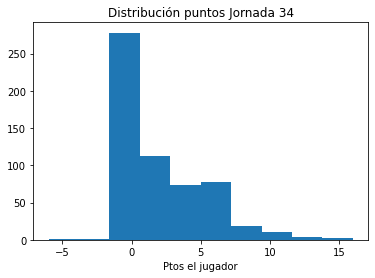

In [81]:
plt.hist(j_34['J_Actual'], bins=10);
plt.title('Distribución puntos Jornada 34')
plt.xlabel('Ptos el jugador');

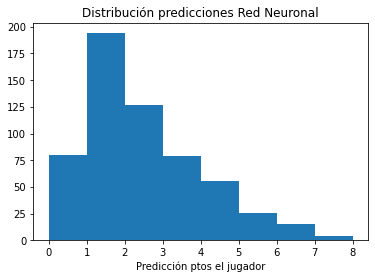

In [82]:
plt.hist(round(preds.rnn), bins=8);
plt.title('Distribución predicciones Red Neuronal')
plt.xlabel('Predicción ptos el jugador');


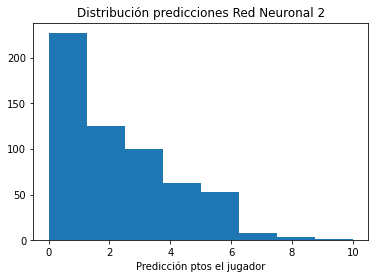

In [83]:
plt.hist(round(preds.rnn2), bins=8);
plt.title('Distribución predicciones Red Neuronal 2')
plt.xlabel('Predicción ptos el jugador');

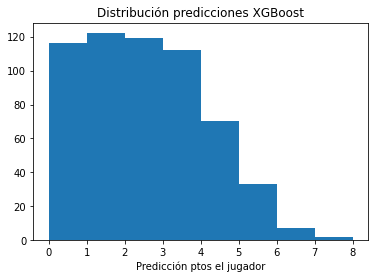

In [84]:
plt.hist(round(preds.xgb), bins=8);
plt.title('Distribución predicciones XGBoost')
plt.xlabel('Predicción ptos el jugador');

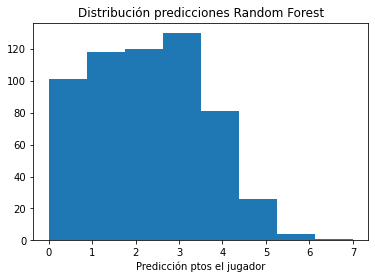

In [85]:
plt.hist(round(preds.rfr), bins=8);
plt.title('Distribución predicciones Random Forest')
plt.xlabel('Predicción ptos el jugador');

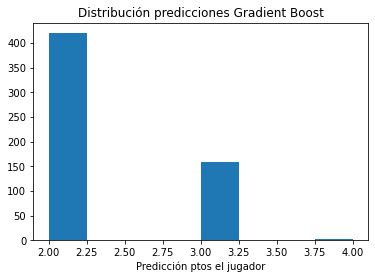

In [86]:
plt.hist(round(preds.gb), bins=8);
plt.title('Distribución predicciones Gradient Boost')
plt.xlabel('Predicción ptos el jugador');

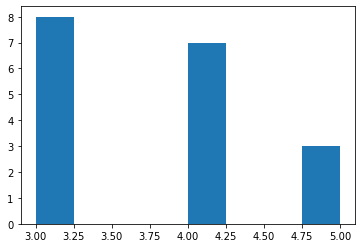

In [36]:
plt.hist(round(df_squad_kike.rfr), bins=8);

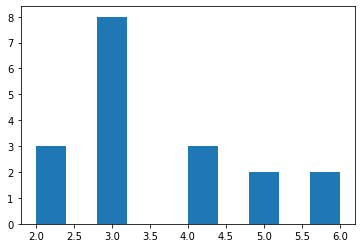

In [37]:
plt.hist(df_squad_kike.rnn);

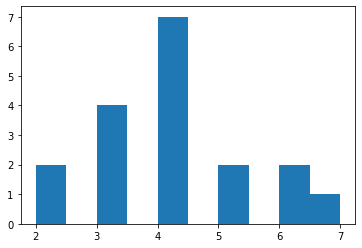

In [40]:
plt.hist(df_squad_kike.rnn2);

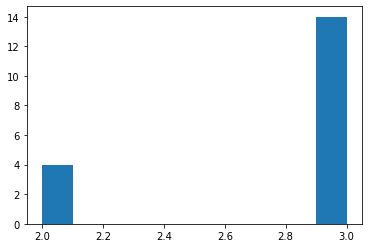

In [38]:
plt.hist(df_squad_kike.gb);

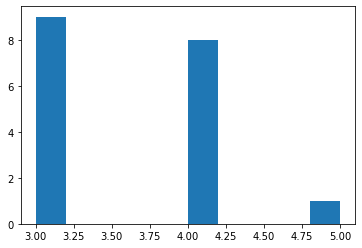

In [39]:
plt.hist(df_squad_kike.xgb);

In [41]:
preds.rnn.value_counts()


1.0    194
2.0    124
0.0     80
3.0     79
4.0     56
5.0     26
6.0     15
7.0      3
8.0      1
Name: rnn, dtype: int64

In [42]:
preds.rnn2.value_counts()

1.0     181
2.0     125
3.0      97
4.0      63
0.0      46
5.0      38
6.0      15
7.0       8
8.0       4
10.0      1
Name: rnn2, dtype: int64

In [43]:
preds.xgb.value_counts()

1.0    122
2.0    119
0.0    116
3.0    109
4.0     70
5.0     33
6.0      7
7.0      1
8.0      1
Name: xgb, dtype: int64

In [44]:
preds.gb.value_counts()

2.0    417
3.0    158
4.0      3
Name: gb, dtype: int64

In [45]:
preds.rfr.value_counts()

3.0    127
2.0    120
1.0    118
0.0    101
4.0     81
5.0     26
6.0      4
7.0      1
Name: rfr, dtype: int64

In [66]:
j_33.to_csv('comunio_data_j_33.csv', index=False)


In [50]:
import sqlite3


conn = sqlite3.connect('../../ComunioApp/ComunioApp2/db.sqlite3')
c = conn.cursor()
j_34.to_sql('j_34', conn, if_exists='append', index = False, chunksize = 10000)